# Language Knowledge (Vocabulary)
Duration: 30 minutes
Content: This section tests your knowledge of Japanese vocabulary, including kanji readings, orthography, word formation, contextually-defined expressions, paraphrases, and usage
It mainly composes following five categories:
- ``Reading Kana`` (Pronunciation Questions): Given a kanji word, choose the correct kana reading.
- `Writing Kanji` (Writing Questions): Given a word written in kana, choose the correct kanji representation.
- `Word Meaning` Selection (Vocabulary Understanding): Choose the most suitable word to fill in the sentence from four options.
- `Synonym Replacement`: Select a word that has the same or similar meaning as the underlined word.
- `Vocabulary Usage`: Assess the usage of words in actual contexts, choosing the most appropriate word usage, including some common Japanese expressions or fixed phrases.

In [19]:
import pandas as pd
import json
import os
import random
import pickle
import re
import uuid
from typing import *
from langchain_openai import AzureOpenAI,AzureChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from dotenv import load_dotenv
from langchain_aws import ChatBedrock
from langchain.embeddings.base import Embeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain_community.embeddings import XinferenceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from IPython.display import display, Markdown, Latex
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage,RemoveMessage,HumanMessage,AIMessage,ToolMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional
from langchain_tavily import TavilySearch
from langchain.schema import Document
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from Libs.LLMs import azure_llm, aws_llm
load_dotenv()

True

In [20]:
# Import N3 Vocabulary
file_path = '../../Vocab/n3.csv'
# Read the CSV file
data = pd.read_csv(file_path)
words = data.iloc[:, :2].sample(frac=1).reset_index(drop=True)
# Display the content of the CSV file
words.head()
vocab_dict = words.set_index(words.columns[0])[words.columns[1]].to_dict()
vocab_dict = json.dumps(vocab_dict, ensure_ascii=False, separators=(',', ':'))

#### load Models

#### Exam Paper Outline
### A. overall thinking the structure of an exam
1. distribution of the difficulty 
2. topics
3. reasoning

## Data Strcuture

# Kanji 读假名（读音问题）

In [21]:
def online_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    
    print("---WEB SEARCH---")
    
    topic = state['messages'][0].content
    
    tavily_search_tool = TavilySearch(
        max_results=5,
        topic="general",
        time_range="day",
    )
    # Web search
    docs = tavily_search_tool.invoke({"query": topic})
    
    print(docs)

    web_results = "\n".join([d["content"] for d in docs["results"]])
    
    print("Web results: ", web_results)

    return {"documents": web_results, "topic": topic}

In [22]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class QuestionState(TypedDict):
    topic: str
    question: str
    documents: str
    messages: Annotated[list, add_messages]


example = """
9. ここから じゅんばん に見てください。
	1.	順番
	2.	項番
	3.	順落
	4.	項落

10. 父は銀行に つとめて います。
	1.	勧めて
	2.	勤めて
	3.	仕めて
	4.	労めて

11. ポケットが さゆう にあるんですね。
	1.	裏表
	2.	右左
	3.	表裏
	4.	左右

12. 昨日の試合は まけて しまいました。
	1.	退けて
	2.	負けて
	3.	失けて
	4.	欠けて

13. かこの 例も調べてみましょう。
	1.	適去
	2.	過古
	3.	過去
	4.	適古

14. この資料はページが ぎゃく になっていますよ。
	1.	達
	2.	変
	3.	逆
	4.	別
"""

# Nodes
def question_draft_generator(state: QuestionState):
    """First LLM call to generate initial question"""
    print("---Generator----")
        
    search_result = state['documents'],
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
                    You are a Japanese teacher. Your job is to write a vocabulary question for candidates to identify the correct kanji writing of a given word in hiragana for a JLPT N3 level exam paper. Each question presents a word in hiragana within a sentence, and candidates must choose the correct kanji representation from four options. The options should include one correct kanji form and three distractors that are plausible but incorrect. The JLPT exam paper includes a mix of easy, moderate, and difficult questions to accurately assess the test-taker’s proficiency across different aspects of the language.
                    The vocabulary should be restricted to N3 level, use the vocabulary in the `Dictionary` as much as you can.
                    Please refer to the question examples following the formal exam paper. please highlight the word to ask candidate with <u><em></em></u>.
                    Append the correct answer and explanation of the main challenges on why the teacher asks this question to the candidate in simplified Chinese at each question.
                    Finally, output beautiful markdown format.
                    Dictionary: {vocab_dict}
                    Search result: {search_result}
                    Formal exam paper: {example}
                """
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    input = { "topic" : state['topic'],
              "search_result": search_result, 
              "vocab_dict": vocab_dict,
              "example": example,
              "messages": state["messages"]
              }
    # final_message = prompt.format_messages(**input)
    # print(final_message)
    
    generate = prompt | aws_llm
    
    res = generate.invoke(input=input)
    
    print("AI Suggestions: ", res.content)
    
    return {"question": res.content, "messages": [AIMessage(content=res.content)] }

def reflection_node(state: QuestionState) -> QuestionState:
    print("---REVISOR---")
    
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]

    reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """you are a Japanese language educator reviewing a JLPT exam paper. Generate critique and recommendations for the user's submission.
            the review focuses on content accuracy and question quality. 
            - For content accuracy, you must verify that the grammar and vocabulary questions accurately reflect the appropriate JLPT N3 level, ensuring the reading passages are clear, relevant, and appropriately challenging. 
            - For question quality, you must ensure all questions are clearly worded and free from ambiguity to comprehensively assess different language skills, and confirm that the difficulty level of the questions matches the intended JLPT N3 level.
            - During detailed refinement, you check the format and presentation of the paper, ensuring it is well-organized and the instructions are clear and concise. you also ensure the content is culturally appropriate and relevant to Japanese language and culture.
            - Finally, you make give feedback, providing detailed recommendations, including requests.If you think the exam paper is good enough, you just say "GOOD ENOUGH" and not to output anything else.
            """
        ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    reflect = reflection_prompt | azure_llm
    
    res = reflect.invoke(translated)
    
    print("AI Suggestions: ",res.content)
    
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}



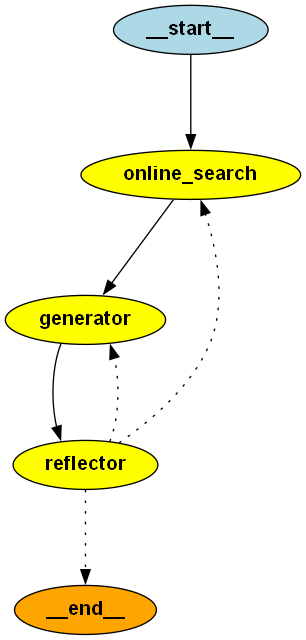

In [23]:
# Build workflow
builder = StateGraph(QuestionState)

builder.add_node("online_search", online_search)
builder.add_node("generator", question_draft_generator)
builder.add_node("reflector", reflection_node)
# Add nodes

def should_continue(state: QuestionState):
    if state["messages"]:
        if len(state["messages"]) > 6: 
            print("--- Reach the Maximum Round ---")
            return END
        elif "GOOD ENOUGH" in state["messages"][-1].content:
            print("--- AI Reviser feels Good Enough ---")
            return END
    return "generator"

# Add edges to connect nodes
builder.add_edge(START, "online_search")
builder.add_edge("online_search", "generator")
builder.add_edge("generator","reflector")
# 
builder.add_conditional_edges("reflector", should_continue)
memory = MemorySaver()

# Compile
kanji_graph = builder.compile()

# Show workflow
display(Image(kanji_graph.get_graph().draw_png()))

In [24]:
row = words.iloc[1]
word = f"{row[0]}({row[1]})"
word

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7928\878816679.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = f"{row[0]}({row[1]})"


'インク(インク)'

In [25]:
kanji = kanji_graph.invoke(
    {
       "messages": [
                HumanMessage(
                    content=word
                )
            ],
        },
    config={"configurable": {"thread_id": "1"}}
)
display(Markdown(kanji["question"]))

---WEB SEARCH---
{'query': 'インク(インク)', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '️「インクついちゃった!」そんなとき、まず読んでほしい話', 'url': 'https://note.com/kakemizu226446/n/n2ed5941bc440', 'content': '「わ〜!シャツにインクつけちゃった!」 そんなとき、ついやってしまいがちなのが… ・とにかく水で流す ・ゴシゴシこする ・お湯で洗ってみる ・ドライヤーで乾かす …実はこれ、どれもngなんです〜💦 インクって、水やお湯に反応して広がったり、 熱で定着してしまったりすることが', 'score': 0.16020063, 'raw_content': None}, {'title': '黒インク 赤ラメに惚れる | 市民aの手慰み', 'url': 'https://simblo.net/u/LgJX4T/post/305354', 'content': '黒インクと赤ラメ良すぎない!？ # 《デュアルメタリックブラッシュ blackインク redラメ》 《紙の表面に沈着する顔料の効果もあって、特に水分を吸う紙と相性がよい》 以前購入した「ぺんてる デュ…', 'score': 0.14680773, 'raw_content': None}, {'title': 'エプソンのプリンタ複合機を購入しようと思っています。EW-M757です。... - Yahoo!知恵袋', 'url': 'https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q11313647796', 'content': 'エプソンのプリンタ複合機を購入しようと思っています。EW-M757です。インクは「タケトンボ／ケンダマ」と書かれています。 モノクロ印刷しかする予定がないのですが、5色のインクセットを買わなければならないのでしょうか。', 'score': 0.10339523, 'raw_content': None}, {'title': '10348293 | OKWAVEメディア,OKWAV

You're absolutely right. I appreciate the comprehensive and detailed critique of the previous question. Let me create a more appropriate N3-level vocabulary question that addresses the concerns you've raised:

### Vocabulary Question

以下の文章の <u><em>インク</em></u> に最も適切な意味はどれですか？

「プリンターの <u><em>インク</em></u> が切れそうです。早く交換しないと印刷できません。」

1. 墨
2. 絵の具
3. 液体
4. 印刷物

**正解：3. 液体**

#### 解説（中文）：
这个问题更好地考察了「インク」在日常语境中的含义。选项3「液体」最准确地描述了打印机墨水的特性。这个问题不再强求为外来语找汉字表示，而是测试学生对词语在具体语境中意义的理解。

**出题意图：**
- 考察考生对词语在特定语境中的理解能力
- 测试对日常技术词汇的准确理解
- 避免不必要地将外来语转换为汉字

**解析：**
- 选项1「墨」：传统书法用墨，不符合现代打印机墨水的语境
- 选项2「绘画颜料」：不是打印机使用的墨水
- 选项3「液体」：最准确地描述打印机墨水的物理特性
- 选项4「印刷物」：指印刷结果，而非墨水本身

这个问题更加符合N3级别的语言测试要求，既考察了词汇理解，又体现了实际语言使用。